In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb

In [2]:
# the data is from
# https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
df = pd.read_csv('./input/creditcard.csv')
df.head(1)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0


In [3]:
df.shape

(284807, 31)

In [4]:
df.columns = [c.lower() for c in df.columns]

<AxesSubplot:>

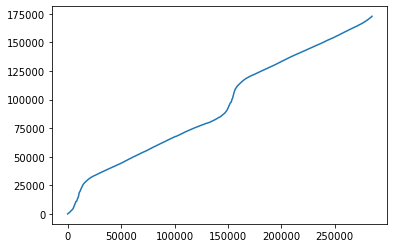

In [5]:
df.time.plot()

In [6]:
df.describe()

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v21,v22,v23,v24,v25,v26,v27,v28,amount,class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [7]:
df['class'].value_counts()

0    284315
1       492
Name: class, dtype: int64

In [8]:
X = df.drop(['time', 'class'], axis=1).values
y = df['class'].values

# With no treatment

In [52]:
# stratified kfold split
kf = StratifiedKFold(n_splits=5, shuffle=True)
oof = np.zeros(len(y))

# cv iterate through splits
for train_index, eval_index in kf.split(X, y):
    X_train, X_eval = X[train_index], X[eval_index]
    y_train, y_eval = y[train_index], y[eval_index]
    
    # prepare datasets
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_eval, y_eval, reference=lgb_train)

    # LightGBM hyperparameters
    lgbm_params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbose': 0,
    }

    model = lgb.train(lgbm_params, lgb_train,
                        # validation data for the model
                        valid_sets=lgb_eval,
                        # train up to 10000 rounds
                        num_boost_round=10000,
                        # if the score doesn't increase for 10 rounds, stop training
                        early_stopping_rounds=10)

    # predict holdout with the trained model
    y_pred_proba = model.predict(X_eval, num_iteration=model.best_iteration)
    oof[eval_index] = (y_pred_proba > 0.5).astype(int)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	valid_0's binary_logloss: 0.0164645
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.0521998
[3]	valid_0's binary_logloss: 0.0212147
[4]	valid_0's binary_logloss: 0.0242963
[5]	valid_0's binary_logloss: 0.0240597
[6]	valid_0's binary_logloss: 0.0251362
[7]	valid_0's binary_logloss: 0.0245098
[8]	valid_0's binary_logloss: 0.025413
[9]	valid_0's binary_logloss: 0.0288472
[10]	valid_0's binary_logloss: 0.0245127
[11]	valid_0's binary_logloss: 0.0277525
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.0164645
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005784 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[1]	valid_0's binary_logloss:

In [53]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
print('accuracy_score, precision_score, recall_score, f1_score, roc_auc_score')
score_funcs = [accuracy_score, precision_score, recall_score, f1_score, roc_auc_score]
scores = [round(f(y, oof) ,3) for f in score_funcs]
print(', '.join(map(str, scores)))

accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
0.999, 0.716, 0.823, 0.766, 0.911


# set weight

In [54]:
from sklearn.utils.class_weight import compute_sample_weight

# stratified kfold split
kf = StratifiedKFold(n_splits=5, shuffle=True)
oof = np.zeros(len(y))

# cv iterate through splits
for train_index, eval_index in kf.split(X, y):
    X_train, X_eval = X[train_index], X[eval_index]
    y_train, y_eval = y[train_index], y[eval_index]

    # prepare datasets
    train_weight = compute_sample_weight(class_weight='balanced', y=y_train).astype('float32')
    lgb_train = lgb.Dataset(X_train, y_train, weight=train_weight)
    lgb_eval = lgb.Dataset(X_eval, y_eval, reference=lgb_train)

    # LightGBM hyperparameters
    lgbm_params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbose': 0,
    }

    model = lgb.train(lgbm_params, lgb_train,
                        # validation data for the model
                        valid_sets=lgb_eval,
                        # train up to 10000 rounds
                        num_boost_round=10000,
                        # if the score doesn't increase for 10 rounds, stop training
                        early_stopping_rounds=10)

    # predict holdout with the trained model
    y_pred_proba = model.predict(X_eval, num_iteration=model.best_iteration)
    oof[eval_index] = (y_pred_proba > 0.5).astype(int)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032823 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	valid_0's binary_logloss: 0.603465
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.52996
[3]	valid_0's binary_logloss: 0.468555
[4]	valid_0's binary_logloss: 0.416593
[5]	valid_0's binary_logloss: 0.371839
[6]	valid_0's binary_logloss: 0.333513
[7]	valid_0's binary_logloss: 0.29957
[8]	valid_0's binary_logloss: 0.269932
[9]	valid_0's binary_logloss: 0.244039
[10]	valid_0's binary_logloss: 0.220478
[11]	valid_0's binary_logloss: 0.199805
[12]	valid_0's binary_logloss: 0.181276
[13]	valid_0's binary_logloss: 0.164792
[14]	valid_0's binary_logloss: 0.150012
[15]	valid_0's binary_logloss: 0.136734
[16]	valid_0's binary_logloss: 0.124935
[17]	valid_0's binary_logloss: 0.114161
[18]	valid_0's binary_logloss: 0.104686
[19]	valid_0's binary_logloss: 0.0959278
[20]	valid_0's binary_lo

In [55]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
print('accuracy_score, precision_score, recall_score, f1_score, roc_auc_score')
score_funcs = [accuracy_score, precision_score, recall_score, f1_score, roc_auc_score]
scores = [round(f(y, oof) ,3) for f in score_funcs]
print(', '.join(map(str, scores)))

accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
0.999, 0.86, 0.825, 0.842, 0.912


# undersampling

In [56]:
from imblearn.under_sampling import RandomUnderSampler

# stratified kfold split
kf = StratifiedKFold(n_splits=5, shuffle=True)
oof = np.zeros(len(y))

# cv iterate through splits
for train_index, eval_index in kf.split(X, y):
    X_train, X_eval = X[train_index], X[eval_index]
    y_train, y_eval = y[train_index], y[eval_index]

    # prepare datasets
    rus = RandomUnderSampler(random_state=0, replacement=True)
    X_train, y_train = rus.fit_resample(X_train, y_train)
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_eval, y_eval, reference=lgb_train)

    # LightGBM hyperparameters
    lgbm_params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbose': 0,
    }

    model = lgb.train(lgbm_params, lgb_train,
                        # validation data for the model
                        valid_sets=lgb_eval,
                        # train up to 10000 rounds
                        num_boost_round=10000,
                        # if the score doesn't increase for 10 rounds, stop training
                        early_stopping_rounds=10)

    # predict holdout with the trained model
    y_pred_proba = model.predict(X_eval, num_iteration=model.best_iteration)
    oof[eval_index] = (y_pred_proba > 0.5).astype(int)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's binary_logloss: 0.617871
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's binary_logloss: 0.5552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's binary_logloss: 0.503238
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's binary_logloss: 0.458263
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's binary_logloss: 0.420256
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's binary_logloss: 0.386685
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7]	valid_0's bin

In [57]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
print('accuracy_score, precision_score, recall_score, f1_score, roc_auc_score')
score_funcs = [accuracy_score, precision_score, recall_score, f1_score, roc_auc_score]
scores = [round(f(y, oof) ,3) for f in score_funcs]
print(', '.join(map(str, scores)))

accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
0.968, 0.048, 0.925, 0.092, 0.947


# oversampling

In [58]:
from imblearn.over_sampling import RandomOverSampler

# stratified kfold split
kf = StratifiedKFold(n_splits=5, shuffle=True)
oof = np.zeros(len(y))

# cv iterate through splits
for train_index, eval_index in kf.split(X, y):
    X_train, X_eval = X[train_index], X[eval_index]
    y_train, y_eval = y[train_index], y[eval_index]

    # prepare datasets
    ros = RandomOverSampler(random_state=0)
    X_train, y_train = ros.fit_resample(X_train, y_train)
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_eval, y_eval, reference=lgb_train)

    # LightGBM hyperparameters
    lgbm_params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbose': 0,
    }

    model = lgb.train(lgbm_params, lgb_train,
                        # validation data for the model
                        valid_sets=lgb_eval,
                        # train up to 10000 rounds
                        num_boost_round=10000,
                        # if the score doesn't increase for 10 rounds, stop training
                        early_stopping_rounds=10)

    # predict holdout with the trained model
    y_pred_proba = model.predict(X_eval, num_iteration=model.best_iteration)
    oof[eval_index] = (y_pred_proba > 0.5).astype(int)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	valid_0's binary_logloss: 0.604255
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.531487
[3]	valid_0's binary_logloss: 0.470168
[4]	valid_0's binary_logloss: 0.418081
[5]	valid_0's binary_logloss: 0.37347
[6]	valid_0's binary_logloss: 0.335005
[7]	valid_0's binary_logloss: 0.301208
[8]	valid_0's binary_logloss: 0.271202
[9]	valid_0's binary_logloss: 0.244864
[10]	valid_0's binary_logloss: 0.2217
[11]	valid_0's binary_logloss: 0.200479
[12]	valid_0's binary_logloss: 0.182119
[13]	valid_0's binary_logloss: 0.165749
[14]	valid_0's binary_logloss: 0.151097
[15]	valid_0's binary_logloss: 0.13741
[16]	valid_0's binary_logloss: 0.125748
[17]	valid_0's binary_logloss: 0.115045
[18]	valid_0's binary_logloss: 0.105319
[19]	valid_0's binary_logloss: 0.0965134
[20]	valid_0's binary_logl

In [59]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
print('accuracy_score, precision_score, recall_score, f1_score, roc_auc_score')
score_funcs = [accuracy_score, precision_score, recall_score, f1_score, roc_auc_score]
scores = [round(f(y, oof) ,3) for f in score_funcs]
print(', '.join(map(str, scores)))

accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
0.999, 0.836, 0.821, 0.829, 0.91


# SMOTE

In [60]:
from imblearn.over_sampling import SMOTE 

# stratified kfold split
kf = StratifiedKFold(n_splits=5, shuffle=True)
oof = np.zeros(len(y))

# cv iterate through splits
for train_index, eval_index in kf.split(X, y):
    X_train, X_eval = X[train_index], X[eval_index]
    y_train, y_eval = y[train_index], y[eval_index]

    # prepare datasets
    sm = SMOTE(random_state=0)
    X_train, y_train = sm.fit_resample(X_train, y_train)
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_eval, y_eval, reference=lgb_train)

    # LightGBM hyperparameters
    lgbm_params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbose': 0,
    }

    model = lgb.train(lgbm_params, lgb_train,
                        # validation data for the model
                        valid_sets=lgb_eval,
                        # train up to 10000 rounds
                        num_boost_round=10000,
                        # if the score doesn't increase for 10 rounds, stop training
                        early_stopping_rounds=10)

    # predict holdout with the trained model
    y_pred_proba = model.predict(X_eval, num_iteration=model.best_iteration)
    oof[eval_index] = (y_pred_proba > 0.5).astype(int)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	valid_0's binary_logloss: 0.605903
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.534409
[3]	valid_0's binary_logloss: 0.474183
[4]	valid_0's binary_logloss: 0.423073
[5]	valid_0's binary_logloss: 0.379121
[6]	valid_0's binary_logloss: 0.340916
[7]	valid_0's binary_logloss: 0.3076
[8]	valid_0's binary_logloss: 0.278506
[9]	valid_0's binary_logloss: 0.252921
[10]	valid_0's binary_logloss: 0.230286
[11]	valid_0's binary_logloss: 0.210248
[12]	valid_0's binary_logloss: 0.192463
[13]	valid_0's binary_logloss: 0.176497
[14]	valid_0's binary_logloss: 0.162184
[15]	valid_0's binary_logloss: 0.149018
[16]	valid_0's binary_logloss: 0.137475
[17]	valid_0's binary_logloss: 0.126924
[18]	valid_0's binary_logloss: 0.117314
[19]	valid_0's binary_logloss: 0.108659
[20]	valid_0's binary_log

In [61]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
print('accuracy_score, precision_score, recall_score, f1_score, roc_auc_score')
score_funcs = [accuracy_score, precision_score, recall_score, f1_score, roc_auc_score]
scores = [round(f(y, oof) ,3) for f in score_funcs]
print(', '.join(map(str, scores)))

accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
0.999, 0.632, 0.85, 0.725, 0.924


# ADASYN

In [62]:
from imblearn.over_sampling import ADASYN 

# stratified kfold split
kf = StratifiedKFold(n_splits=5, shuffle=True)
oof = np.zeros(len(y))

# cv iterate through splits
for train_index, eval_index in kf.split(X, y):
    X_train, X_eval = X[train_index], X[eval_index]
    y_train, y_eval = y[train_index], y[eval_index]

    # prepare datasets
    ad = ADASYN(random_state=0)
    X_train, y_train = ad.fit_resample(X_train, y_train)
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_eval, y_eval, reference=lgb_train)

    # LightGBM hyperparameters
    lgbm_params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbose': 0,
    }

    model = lgb.train(lgbm_params, lgb_train,
                        # validation data for the model
                        valid_sets=lgb_eval,
                        # train up to 10000 rounds
                        num_boost_round=10000,
                        # if the score doesn't increase for 10 rounds, stop training
                        early_stopping_rounds=10)

    # predict holdout with the trained model
    y_pred_proba = model.predict(X_eval, num_iteration=model.best_iteration)
    oof[eval_index] = (y_pred_proba > 0.5).astype(int)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	valid_0's binary_logloss: 0.61512
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.549664
[3]	valid_0's binary_logloss: 0.494712
[4]	valid_0's binary_logloss: 0.448109
[5]	valid_0's binary_logloss: 0.408537
[6]	valid_0's binary_logloss: 0.37296
[7]	valid_0's binary_logloss: 0.341653
[8]	valid_0's binary_logloss: 0.313967
[9]	valid_0's binary_logloss: 0.289218
[10]	valid_0's binary_logloss: 0.267809
[11]	valid_0's binary_logloss: 0.247853
[12]	valid_0's binary_logloss: 0.230516
[13]	valid_0's binary_logloss: 0.214906
[14]	valid_0's binary_logloss: 0.200797
[15]	valid_0's binary_logloss: 0.187505
[16]	valid_0's binary_logloss: 0.176417
[17]	valid_0's binary_logloss: 0.16557
[18]	valid_0's binary_logloss: 0.155917
[19]	valid_0's binary_logloss: 0.147209
[20]	valid_0's binary_logl

In [63]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
print('accuracy_score, precision_score, recall_score, f1_score, roc_auc_score')
score_funcs = [accuracy_score, precision_score, recall_score, f1_score, roc_auc_score]
scores = [round(f(y, oof) ,3) for f in score_funcs]
print(', '.join(map(str, scores)))

accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
0.999, 0.679, 0.827, 0.746, 0.913


# undersampling + bagging


In [64]:
from imblearn.under_sampling import RandomUnderSampler

def undersample_bagg(X_train, X_eval, y_train, y_eval):
    # prepare datasets
    rus = RandomUnderSampler(replacement=True)
    X_train, y_train = rus.fit_resample(X_train, y_train)
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_eval, y_eval, reference=lgb_train)

    # LightGBM hyperparameters
    lgbm_params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbose': 0,
    }

    model = lgb.train(lgbm_params, lgb_train,
                        # validation data for the model
                        valid_sets=lgb_eval,
                        # train up to 10000 rounds
                        num_boost_round=10000,
                        # if the score doesn't increase for 10 rounds, stop training
                        early_stopping_rounds=10)

    # predict holdout with the trained model
    y_pred_proba = model.predict(X_eval, num_iteration=model.best_iteration)

    return y_pred_proba

# stratified kfold split
kf = StratifiedKFold(n_splits=5, shuffle=True)
oof = np.zeros(len(y))

# cv iterate through splits
for train_index, eval_index in kf.split(X, y):
    X_train, X_eval = X[train_index], X[eval_index]
    y_train, y_eval = y[train_index], y[eval_index]

    n_bagging = 10
    preds = [undersample_bagg(X_train, X_eval, y_train, y_eval) for i in range(n_bagging)]
    y_pred_proba = sum(preds) / n_bagging

    oof[eval_index] = (y_pred_proba > 0.5).astype(int)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's binary_logloss: 0.617736
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's binary_logloss: 0.554238
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's binary_logloss: 0.50238
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's binary_logloss: 0.455595
[5]	valid_0's binary_logloss: 0.416306
[6]	valid_0's binary_logloss: 0.381721
[7]	valid_0's binary_logloss: 0.351766
[8]	valid_0's binary_logloss: 0.326449
[9]	valid_0's binary_logloss: 0.303834
[10]	valid_0's binary_logloss: 0.284316
[11]	valid_0's binary_logloss: 0.266788
[12]	valid_0's binary_logloss: 0.250624
[13]

In [65]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
print('accuracy_score, precision_score, recall_score, f1_score, roc_auc_score')
score_funcs = [accuracy_score, precision_score, recall_score, f1_score, roc_auc_score]
scores = [round(f(y, oof) ,3) for f in score_funcs]
print(', '.join(map(str, scores)))

accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
0.973, 0.056, 0.909, 0.105, 0.941


# undersampling + bagging + calib


In [66]:
from imblearn.under_sampling import RandomUnderSampler

def calibrate(prob, beta):
    return prob / (prob + (1 - prob) / beta)

def undersample_bagg(X_train, X_eval, y_train, y_eval):
    # prepare datasets
    rus = RandomUnderSampler(replacement=True)
    X_train, y_train = rus.fit_resample(X_train, y_train)
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_eval, y_eval, reference=lgb_train)

    # LightGBM hyperparameters
    lgbm_params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbose': 0,
    }

    model = lgb.train(lgbm_params, lgb_train,
                        # validation data for the model
                        valid_sets=lgb_eval,
                        # train up to 10000 rounds
                        num_boost_round=10000,
                        # if the score doesn't increase for 10 rounds, stop training
                        early_stopping_rounds=10)

    # predict holdout with the trained model
    y_pred_proba = model.predict(X_eval, num_iteration=model.best_iteration)
    # undersampling rate
    us_rate = sum(y_train == 1) / sum(y == 0)
    # calibrate probability
    y_pred_proba = calibrate(y_pred_proba, us_rate)

    return y_pred_proba

# stratified kfold split
kf = StratifiedKFold(n_splits=5, shuffle=True)
oof = np.zeros(len(y))

# cv iterate through splits
for train_index, eval_index in kf.split(X, y):
    X_train, X_eval = X[train_index], X[eval_index]
    y_train, y_eval = y[train_index], y[eval_index]

    n_bagging = 10
    preds = [undersample_bagg(X_train, X_eval, y_train, y_eval) for i in range(n_bagging)]
    y_pred_proba = sum(preds) / n_bagging

    oof[eval_index] = (y_pred_proba > 0.5).astype(int)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's binary_logloss: 0.617444
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's binary_logloss: 0.554568
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's binary_logloss: 0.503001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's binary_logloss: 0.458165
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's binary_logloss: 0.420083
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's binary_logloss: 0.387271
[7]	valid_0's binary_logloss: 0.357717
[8]	valid_0's binary_logloss: 0.331386
[9]	valid_0'

In [67]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
print('accuracy_score, precision_score, recall_score, f1_score, roc_auc_score')
score_funcs = [accuracy_score, precision_score, recall_score, f1_score, roc_auc_score]
scores = [round(f(y, oof) ,3) for f in score_funcs]
print(', '.join(map(str, scores)))

accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
0.999, 0.846, 0.77, 0.806, 0.885


# undersampling + calib


In [68]:
from imblearn.under_sampling import RandomUnderSampler

def calibrate(prob, beta):
    return prob / (prob + (1 - prob) / beta)

# stratified kfold split
kf = StratifiedKFold(n_splits=5)
oof = np.zeros(len(y))

# cv iterate through splits
for train_index, eval_index in kf.split(X, y):
    X_train, X_eval = X[train_index], X[eval_index]
    y_train, y_eval = y[train_index], y[eval_index]

    # prepare datasets
    rus = RandomUnderSampler(replacement=True)
    X_train, y_train = rus.fit_resample(X_train, y_train)
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_eval, y_eval, reference=lgb_train)

    # LightGBM hyperparameters
    lgbm_params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbose': 0,
    }

    model = lgb.train(lgbm_params, lgb_train,
                        # validation data for the model
                        valid_sets=lgb_eval,
                        # train up to 10000 rounds
                        num_boost_round=10000,
                        # if the score doesn't increase for 10 rounds, stop training
                        early_stopping_rounds=10)

    # predict holdout with the trained model
    y_pred_proba = model.predict(X_eval, num_iteration=model.best_iteration)
    # undersampling rate
    us_rate = sum(y_train == 1) / sum(y == 0)
    # calibrate probability
    y_pred_proba = calibrate(y_pred_proba, us_rate)

    oof[eval_index] = (y_pred_proba > 0.5).astype(int)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's binary_logloss: 0.627069
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's binary_logloss: 0.569479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's binary_logloss: 0.514699
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's binary_logloss: 0.474064
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's binary_logloss: 0.44121
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's binary_logloss: 0.414147
[7]	valid_0's binary_logloss: 0.379847
[8]	valid_0's binary_logloss: 0.352423
[9]	valid_0's

In [69]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
print('accuracy_score, precision_score, recall_score, f1_score, roc_auc_score')
score_funcs = [accuracy_score, precision_score, recall_score, f1_score, roc_auc_score]
scores = [round(f(y, oof) ,3) for f in score_funcs]
print(', '.join(map(str, scores)))

accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
0.999, 0.817, 0.642, 0.719, 0.821


In [71]:
def generate_markdown_table(txt):
    table = []
    n_cols = -1
    # for each line of table
    for line in score_txt.split('\n'):
        # number of columns
        n_cols = line.count(',') + 1
        row = '|'
        # iterate through elements in a line and make markdown table expression
        for elem in line.strip().split(','):
            row += elem.strip() + '|'
        table.append(row)

    # insert the separator between the header and the body
    table.insert(1, '|' + ':-|' * n_cols)
    table_txt = '\n'.join(table)
    print(table_txt)

score_txt = """condition, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
no treatment, 0.999, 0.716, 0.823, 0.766, 0.911
set weight, 0.999, 0.86, 0.825, 0.842, 0.912
undersampling, 0.968, 0.048, 0.925, 0.092, 0.947
oversampling, 0.999, 0.836, 0.821, 0.829, 0.91
SMOTE, 0.999, 0.632, 0.85, 0.725, 0.924
ADASYN, 0.999, 0.679, 0.827, 0.746, 0.913
undersampling + bagging, 0.973, 0.056, 0.909, 0.105, 0.941
undersampling + bagging + calib, 0.999, 0.846, 0.77, 0.806, 0.885
undersampling + calib, 0.999, 0.817, 0.642, 0.719, 0.821"""

generate_markdown_table(score_txt)

|condition|accuracy_score|precision_score|recall_score|f1_score|roc_auc_score|time|
|:-|:-|:-|:-|:-|:-|
|no treatment|0.999|0.716|0.823|0.766|0.911|
|set weight|0.999|0.86|0.825|0.842|0.912|
|undersampling|0.968|0.048|0.925|0.092|0.947|
|oversampling|0.999|0.836|0.821|0.829|0.91|
|SMOTE|0.999|0.632|0.85|0.725|0.924|
|ADASYN|0.999|0.679|0.827|0.746|0.913|
|undersampling + bagging|0.973|0.056|0.909|0.105|0.941|
|undersampling + bagging + calib|0.999|0.846|0.77|0.806|0.885|
|undersampling + calib|0.999|0.817|0.642|0.719|0.821|
